In [51]:
import warnings
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.interpolate import make_interp_spline
warnings.filterwarnings('ignore')

In [52]:
def removed_outliers(df, column, level=3):
    return df[((df[column] - df[column].mean()) / df[column].std()).abs() < level]

In [53]:
def smoothen_plot(x, y, smooth_power=300):
    smoothened_x = np.linspace(x.min(), x.max(), smooth_power)
    spl = make_interp_spline(x, y, k=3)
    smoothened_y = spl(smoothened_x)
    return smoothened_x, smoothened_y

In [95]:
def plot_ac_u_comp(df, clean=3, smooth_u=False, smooth_ac=False, draw_v_lines=False):
    if clean:
        cleaned_df = removed_outliers(df, 'ac_iter_time', level=clean)
        cleaned_df = removed_outliers(cleaned_df, 'u_iter_time', level=clean)
        # cleaned_df = cleaned_df.iloc[[i for i in range(len(cleaned_df)) if i % 10 == 0]]
        cleaned_df.reset_index(drop=True, inplace=True)
    else:
        cleaned_df = df

    _, ax = plt.subplots(figsize=(15, 5))

    if smooth_ac:
        new_iter_no, ac_iter_time_smooth = smoothen_plot(cleaned_df.iteration_no, cleaned_df.ac_iter_time, 180)
    else:
        new_iter_no, ac_iter_time_smooth = cleaned_df.iteration_no, cleaned_df.ac_iter_time
    ax.plot(new_iter_no, ac_iter_time_smooth, label='Active cells implementation', c='black', ls='-.')


    if smooth_u:
        new_iter_no, u_iter_time_smooth = smoothen_plot(cleaned_df.iteration_no, cleaned_df.u_iter_time, 180)
    else:
        new_iter_no, u_iter_time_smooth = cleaned_df.iteration_no, cleaned_df.u_iter_time
    ax.plot(new_iter_no, u_iter_time_smooth, label='Unified memory implementation', c='black', ls=':')

    iteration_no = cleaned_df['iteration_no']

    first_100 = (cleaned_df['ac_coverage'] == 100).idxmax()
    # if draw_v_lines:
    #     ax.axvline(x=iteration_no[first_100], lw=1, ls='--', c='black')
    #     ax.text(iteration_no[first_100] - 150, 1300, 'All cells are active', rotation=90)

    cross_point = ((cleaned_df['ac_iter_time'] - cleaned_df['u_iter_time']).abs() < 3).idxmax()
    if draw_v_lines:
        ax.axvline(x=iteration_no[cross_point], lw=1, ls='--', c='black')
        ax.text(iteration_no[cross_point] - 150, 1300, 'Iteration time cross point', rotation=90)

    xs = [i for i in range(cleaned_df.shape[0]) if i % 300 == 0] + [cross_point, first_100]
    xticks = [iteration_no[i] for i in xs]

    ax.set_xlabel('Iteration')
    ax.set_ylabel('Iteration time [μs]')
    ax.set_xticks(xticks)

    secax = ax.secondary_xaxis('top')
    secax.set_xlabel('Fraction of active cells in CA')

    secax.set_xticks(xticks)
    secax.set_xticklabels([
        f'{cleaned_df[cleaned_df.iteration_no == i].ac_coverage.iloc[0]:.2f}%'
        for i in xticks
    ])

    plt.legend()
    plt.show()

### Single result

In [55]:
ac_df = pd.read_csv('unical_mount_point/active_cells_gpu_32_4000_10000_36_coverage.csv',
                   skiprows=1, names=['iteration_no', 'ac_coverage', 'ac_iter_time'])
u_df = pd.read_csv('unical_mount_point/unified_memory_32_4000_10000_36_coverage.csv',
                  skiprows=1, names=['iteration_no', 'u_coverage', 'u_iter_time'])
u_df.drop('u_coverage', axis=1, inplace=True)

comp_df = pd.merge(ac_df, u_df, how='inner', on='iteration_no')
comp_df.describe()

,iteration_no,ac_coverage,ac_iter_time,u_iter_time
count,1000.000000,1000.000000,1000.00000,1000.000000
mean,5005.000000,70.896090,676.87500,130.821000
std,2888.194361,32.329847,44947.78501,44692.664234
min,10.000000,0.040725,-997230.00000,-997835.000000
25%,2507.500000,44.260987,1983.00000,1966.750000
50%,5005.000000,84.890250,2151.00000,2115.500000
75%,7502.500000,99.995789,2789.25000,2256.000000
max,10000.000000,100.000000,107766.00000,2664.000000


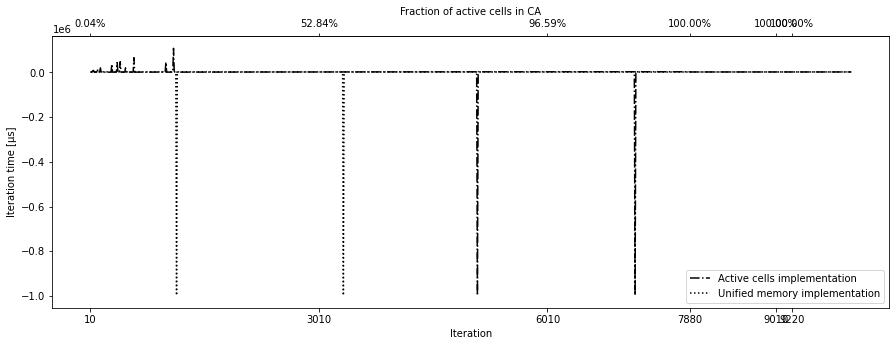

In [56]:
plot_ac_u_comp(comp_df, clean=False, draw_v_lines=False)

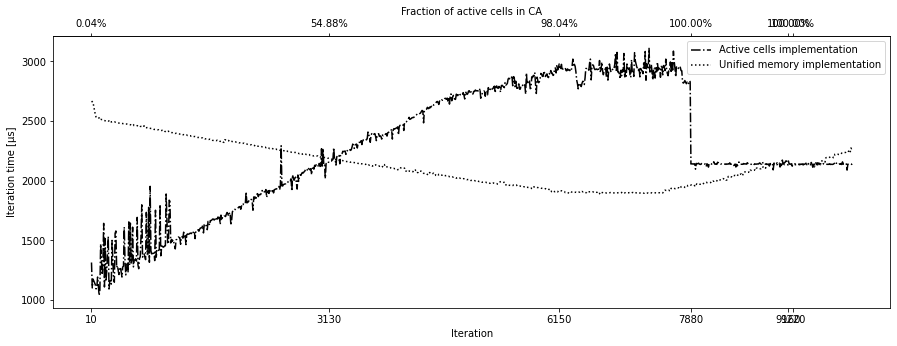

In [57]:
plot_ac_u_comp(comp_df, clean=0.13, draw_v_lines=False)

### Averaged results

In [84]:
ac_to_avg = glob('unical_mount_point/ac_*')

inter_df = pd.DataFrame()
for i, path in enumerate(ac_to_avg):
    df = pd.read_csv(path, skiprows=1, names=['iteration_no', 'ac_coverage', 'ac_iter_time'])
    inter_df[i] = df.ac_iter_time

avg_20_comp = pd.read_csv(ac_to_avg[0], skiprows=1, names=['iteration_no', 'ac_coverage', 'ac_iter_time'])
avg_20_comp['ac_iter_time'] = inter_df.median(axis=1)

u_to_avg = glob('unical_mount_point/u_*')

inter_df = pd.DataFrame()
for i, path in enumerate(u_to_avg):
    df = pd.read_csv(path, skiprows=1, names=['iteration_no', 'u_coverage', 'u_iter_time'])
    inter_df[i] = df.u_iter_time

avg_20_comp['u_iter_time'] = inter_df.median(axis=1)

first_100 = (avg_20_comp['ac_coverage'] == 100).idxmax()
avg_20_comp = avg_20_comp.iloc[:first_100 + 1]

avg_20_comp.describe()

,iteration_no,ac_coverage,ac_iter_time,u_iter_time
count,788.000000,788.000000,788.000000,788.000000
mean,3945.000000,63.066104,2622.582487,2523.992386
std,2276.202979,32.205870,895.130719,145.966968
min,10.000000,0.040725,1237.000000,2333.000000
25%,1977.500000,35.158838,1926.250000,2397.000000
50%,3945.000000,68.667075,2590.250000,2509.500000
75%,5912.500000,95.379361,3379.000000,2620.500000
max,7880.000000,100.000000,14043.000000,3257.000000


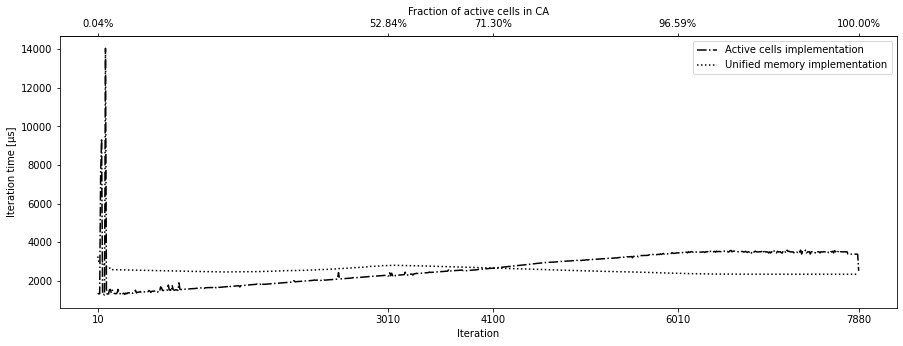

In [96]:
plot_ac_u_comp(avg_20_comp, clean=False, draw_v_lines=False)

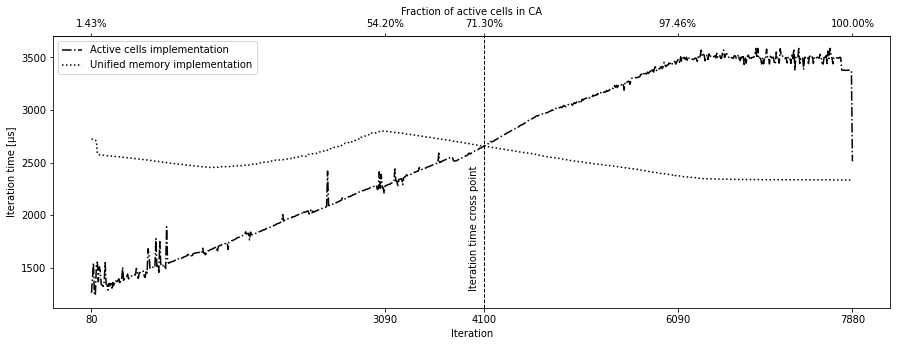

In [97]:
plot_ac_u_comp(avg_20_comp, clean=3, draw_v_lines=True)

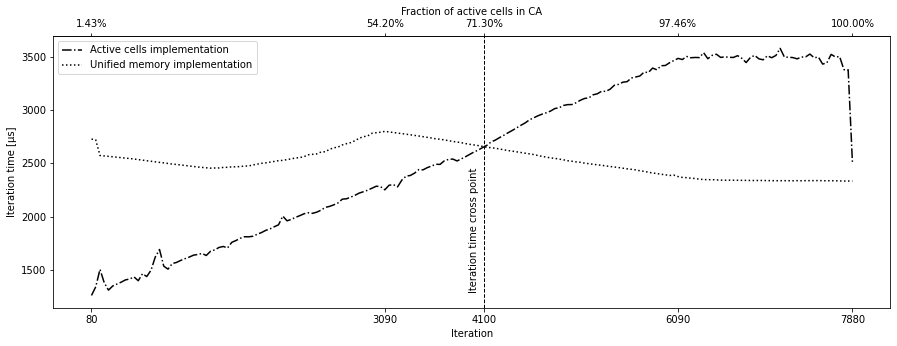

In [98]:
plot_ac_u_comp(avg_20_comp, clean=3, smooth_ac=True, smooth_u=True, draw_v_lines=True)